# Monte Carlo Methods

The basic idea of Monte Carlo Methods is to use random numbers and statistics to solve very complicated problems that are hard to solve in any other way. Typically, this is achieved through simulations, such as Markov chains. However, the most straightforward application is in computing high-dimensional integrals by throwing points into a volume and estimating the result. There are numerous other applications, such as finding global minimums through simulated annealing, drawing inspiration from statistical physics, and so on.

Here we will cover a very small fraction of `Classical Monte Carlo` algorithms. There is a huge set of Monte Carlo algorithms that we will not discuss here.


First we need to understand what are random numbers on a comuter.

## Random Numbers

It is very hard to implement a good random number generator because a sequence of trully random numbers can not be generated by deterministic computers. Only pseudo-random number generators can be coded. There are several excellent pseudo random number generators available in various libraries, which give very satisfactory results in combination
with Monte Carlo methods or multidimensional integrations. For every Monte Carlo application, it is crucial to use high quality random number generator. In practice, it is best to select a few random number generators with a good
reputation, and make sure that results do not depend on the choice of a random number
generator. 

Numpy's default generators are now from <a href="https://www.pcg-random.org/index.html"> `PCG` library</a>, <a href="https://en.wikipedia.org/wiki/Permuted_congruential_generator">wikipedia</a> which has very good reputation, and is very new. Older random number generations with good reputation are `Mersenne Twister` generators, which usually go by the name `rng mt19937`. For example gnu scientific library is implementing them as `gsl_rng_mt19937` and intel `mkl` library is calling them `VSL_BRNG_MT19937` and `VSL_BRNG_SFMT19937`.


**How do random number generators work?**

The simplest and fastest random number generators, which are unfortunately not of 
high quality, are linear congruential generators:
$$I_{j+1}=(a I_j + c)\; \textrm{mod}\; m$$
for example, $a=16843009$, $c=3014898611$, and $m=2^{32}$ in `cc65` generator. 

Modern generators, like <a href="https://www.pcg-random.org/index.html"> `PCG`</a> are of course much better, but still one needs to understand that these are pseudo-random numbers. Before you spent million of CPU hours, you should test that results don't depend on random number generator within stastistical error.

## Multidimensional integration

Multidimensional numeric integration in more than 4 dimensions is more
appropriate for Monte-Carlo than one-dimensional quadratures. If the
function is smooth enough, or we know how to transform integral to
make it smooth, the integration can be performed with MC.  The reason
for MC success is that it's error, according to central limit theorem,
is always proportional to $1/\sqrt{N}$ independent of dimension.

The error of one dimensional quadratures can be estimated: If the number of
points used in each dimension is $N_1$, the number of all points used
in $d$ dimensions is $N=(N_1)^d$. The error for trapezoid rule was
estimated to $1/(N_1)^2$ therefore the error in $d$ dimensions is
$1/N^{2/d}$.
It is therefore clear than for $d=4$ the Monte-Carlo error and the
trapezoid-rule error are equal.


**Straighforward MC**

For more or less flat functions, the integration is straightforward
\begin{eqnarray}
  \int f dV \approx V \langle f\rangle \pm V \sqrt{\frac{\langle
  f^2\rangle-\langle f\rangle^2}{N}}
\end{eqnarray}
here
\begin{eqnarray}
  \langle f\rangle\equiv \frac{1}{N}\sum_{i=0}^{N-1} f(x_i)\\
  \langle f^2\rangle\equiv \frac{1}{N}\sum_{i=0}^{N-1} f^2(x_i)
\end{eqnarray}

If the function $f$ is rapidly varying, the variance is going to be
large and precision of the integral vary bad. The scaling $1/\sqrt{N}$ is
very bad! If one has a lot of computer time and patience, one might
still try to use this method, because it is so straighforward to implement.

If the region $V$ of the integral is complicated and is hard to
generate distribution of points in volume $V$, one can just find a larger and simpler volume
$W$ which contains volume $V$. Then one samples over $W$ and defines
the function $f$ to be zero outside $V$. Of course the error will increase because
number of "good" points is smaller.

### Monte Carlo <a href="https://en.wikipedia.org/wiki/Monte_Carlo_integration">wikipedia</a>.

Example1 : Computing $\pi$ by integrating function $f=1$ inside unit circle, and $f=0$ outside unit circle, but in the box with interval $x=[-1,1]$, $y=[-1,1]$.

In [1]:
from numpy import random

batch = 1000
num_inside = 0
Ntot = 0
for i in range(1000):
    X = random.uniform(low=-1, high=1, size=batch)
    Y = random.uniform(low=-1, high=1, size=batch)
    num_inside += sum(X**2+Y**2<=1)
    Ntot += batch
V = 4
print(V * num_inside/Ntot)

3.145544


Example2: Integrate Gaussian of width=1 inside unit circle: $f=\exp(-x^2-y^2)$ if $x^2+y^2<=1$.
Result is
$$\int_{circle} \exp(-x^2-y^2) dx dy= 2\pi \int_0^1 r dr \exp(-r^2)=\pi (1-1/e)$$

In [2]:
from numpy import *

batch = 1000
faver = 0
Ntot = 0
for i in range(1000):
    X = random.uniform(low=-1, high=1, size=batch)
    Y = random.uniform(low=-1, high=1, size=batch)
    R2 = X**2+Y**2
    is_inside = (R2<=1).astype(int)
    faver += sum(exp(-R2)* is_inside)
    Ntot += batch
V = 4
print(V * faver/Ntot, 'exact=', pi*(1-exp(-1)))

1.9848579448536516 exact= 1.9858653037988714


**Importance sampling**

Usefulness of Monte Carlo becomes more appealing when importance
sampling strategy is implemented. Of course one needs to know something
about the function to implement the strategy, but one is rewarded with
much higher accuracy.

It is simplest to ilustrate the idea in 1D. If one knows that function
$f(x)$ to be integrated is mostly proportional to another function
$w(x)$ in the region where the integral contains most of the weight,
we might want to rewrite the integral
\begin{eqnarray}
  \int f(x)dx = \int \frac{f(x)}{w(x)} w(x) dx
\end{eqnarray}
If weight function $w(x)$ is a simple analytic function, which can be
integrated analytically, and obeys the following constrains
- $w(x)>0$ for every $x$ 
- $\int w(x)dx = 1$
we can define
\begin{eqnarray}
 W(x) = \int_{-\infty}^x w(t)dt \qquad \rightarrow\qquad  dW(x) = w(x)dx
\end{eqnarray}
and rewrite
\begin{eqnarray}
 \int f(x)dx = \int \frac{f(x)}{w(x)} dW(x) = \int
 \frac{f(x(W))}{w(x(W))} dW\rightarrow
 \left\langle \frac{f(x(W))}{w(x(W))}\right\rangle_{W\; uniform\;\in[0,1]}
\nonumber
\end{eqnarray}

If the function $f/w$ on mesh $W$ is reasonably flat,  it can be
efficiently integrated by MC. The error is now proportional to
$$\sqrt{\frac{\langle(f/w)^2\rangle-\langle f/w\rangle^2}{N}}$$ and the error is
therefore greatly reduced.

To implement the algorith, we generate uniform random numbers $r$
in the interval $r\in[0,1]$ which correspond to variable $W$. We can
solve the equaton for $x=W^{-1}(r)$ to get $x$ and use it to evaluate
$f(x)/w(x)$. The random numbers are therefore uniformly distributed on
mesh $W$ while they are non-uniformly distributed on mesh $x$.

This can also be writtens as
\begin{eqnarray}
  \int f(x)dx =\left\langle \frac{f(x)}{w(x)}\right\rangle_{\frac{P(x)}{dx}=w(x)}
\nonumber
\end{eqnarray}
because the distribution of points $x$ is
$$\frac{dP}{dx}=\frac{dP}{dW}\frac{dW}{dx}$$ and since distribution
$\frac{dP}{dW}$ is uniform, and $\frac{dW}{dx}=w(x)$, we have $$\frac{dP}{dx}=w(x)$$.

The archaic example is the **exponential** weight function
\begin{eqnarray}
  w(x) = \frac{1}{\lambda}e^{-x/\lambda}\qquad for\; x>0
\end{eqnarray}
This is equivalent to our exponentially distributed mesh points. Most
of them are going to be close to $0$ and only a few at large $x$.

The integral is $W(x)=1-e^{-x/\lambda}$ which gives for the inverse
$x=-\lambda\ln(1-W)$. The integral
\begin{equation}
  \int_0^\infty f(x)dx=\int_0^1
  \frac{f(-\lambda\ln(1-W))}{w(-\lambda\ln(1-W))} dW =
  \int_0^1 f(-\lambda\ln(1-W))\frac{\lambda dW}{1-W}
\end{equation}
is easily evaluated with MC if $f(x)$ is exponentially falling function.
\begin{eqnarray}
  \int_0^\infty f(x)dx\rightarrow
  \langle \lambda \frac{f(-\lambda\ln(1-W))}{1-W}\rangle_{W\;uniform\in[0,1]}
\end{eqnarray}

Since $\frac{dP}{dW}=1$ ($W$ is uniformly distributed), the probability
for $x$ is $\frac{dP}{dx}=w(x)$, therefore $x$ is exponentially distributed random
number.

We could also write
\begin{eqnarray}
  \int_0^\infty f(x)dx\rightarrow
  \left\langle\frac{f(x)}{\frac{e^{-x/\lambda}}{\lambda}}\right\rangle_{\frac{dP}{dx}=e^{-x/\lambda}/\lambda}
\end{eqnarray}

Example1 :  $\int_0^\infty \exp(-x)\frac{\sin(x)}{x} dx = 0.785398$

First lets check distribution of points after transformation $x=-\log(1-w)$.

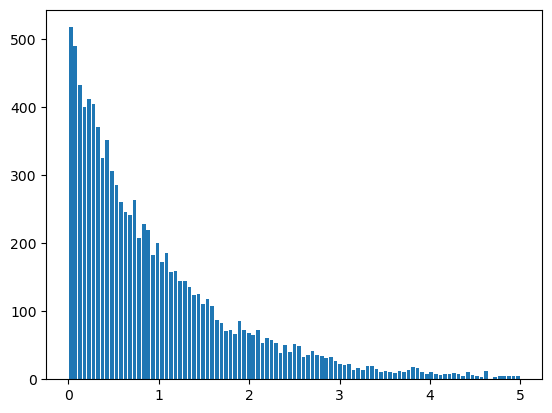

In [3]:
from numpy import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

W = random.uniform(low=0, high=1, size=10000)
X = -log(1-W)
hist, bin_edges = histogram(X, bins=linspace(0,5,100))
xn=0.5*(bin_edges[:-1]+bin_edges[1:])

plt.bar(xn, hist, width=0.04)
plt.show()

In [4]:
def f(x):
    return exp(-x)*sin(x)/x
    
batch = 100

faver = 0
Nall = 0
for i in range(100):
    W = random.uniform(low=0, high=1, size=batch)
    X = -log(1-W)
    faver += sum(f(X)/exp(-X))
    Nall += batch

print(faver/Nall, 'exact=', 0.785398)

0.7896688047293031 exact= 0.785398


Compare with `naive` Monte Carlo

In [5]:
batch = 100

faver = 0
Nall = 0
L=6.

for i in range(100):
    X = random.uniform(low=0, high=L, size=batch)
    faver += sum(f(X))
    Nall += batch

print(L*faver/Nall, 'exact=', 0.785398)

0.787259899398386 exact= 0.785398


Another very usefull weight function is **Gaussian distribution**
\begin{eqnarray}
  w(x) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{(x-x_0)^2}{2\sigma^2}}
\end{eqnarray}
How do we get random number $x$ to be distributed according to the
above distribution? The integral gives $\mathrm{erf}$ function and its
inverse is not simple to evaluate.

The trick is to use two random numbers to get
**Gaussian  distrbution**. Consider the following algorithm
\begin{eqnarray}
  x_1 = x_0 + \sqrt{-2\sigma^2\ln r_1}\cos(2\pi r_2)\\
  x_2 = x_0 + \sqrt{-2\sigma^2\ln r_1}\sin(2\pi r_2)
\end{eqnarray}
The distribution of $r_1$ and $r_2$ is uniform in the interval
$[0,1]$. The distribution of $x_1$ and $x_2$ is
\begin{eqnarray}
  \frac{d^2 P}{dx_1 dx_2} = \frac{d^2 P}{dr_1 dr_2}
  \left|\frac{\partial(r_1,r_2)}{\partial(x_1,x_2)}\right|=
  \frac{1}{\sqrt{2\pi}}e^{-(x_1-x_0)^2/2} \frac{1}{\sqrt{2\pi}}e^{-(x_2-x_0)^2/2} 
\end{eqnarray}
therefore Gaussian. In this way, we can obtaine $x$ to be distributed
gaussian, and we can evaluate
\begin{eqnarray}
 \int f(x)dx = \left\langle \frac{f(x)}{\frac{1}{\sqrt{2\pi\sigma^2}}e^{-(x-x_0)^2/(2\sigma^2)}}
 \right\rangle_{\frac{dP}{dx}=\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{(x-x_0)^2}{2\sigma^2}}}
\end{eqnarray}

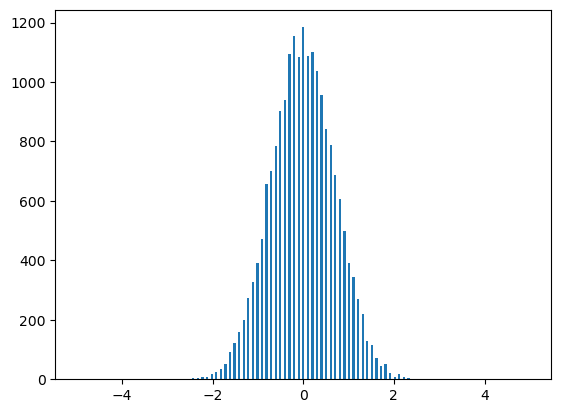

In [6]:
from numpy import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

r1 = random.uniform(low=0, high=1, size=10000)
r2 = random.uniform(low=0, high=1, size=10000)

t = sqrt(-log(1-r1))
X1 = t*cos(2*pi*r2)
X2 = t*sin(2*pi*r2)
X = vstack((X1,X2))

hist, bin_edges = histogram(X, bins=linspace(-5,5,100))
xn=0.5*(bin_edges[:-1]+bin_edges[1:])

plt.bar(xn, hist, width=0.05)
plt.show()

Example2 : $$\int_{-\infty}^{\infty} \exp(-x^2) \frac{sin(x)}{x} dx = 1.6352$$

In [7]:
def f(x):
    return exp(-x**2)*sin(x)/x
    
batch = 100

faver = 0
Nall = 0
spi = sqrt(pi)
for i in range(100):
    r1 = random.uniform(low=0, high=1, size=batch)
    r2 = random.uniform(low=0, high=1, size=batch)
    t = sqrt(-log(1-r1))
    X1 = t*cos(2*pi*r2)
    X2 = t*sin(2*pi*r2)
    #X = vstack((X1,X2))
    faver += sum(f(X1) * spi/exp(-X1**2))+sum(f(X2) * spi/exp(-X2**2))
    Nall += 2*batch

print(faver/Nall, 'exact=', 1.6352)

1.636123726102147 exact= 1.6352


Compare with `naive` Monte Carlo

In [8]:
batch = 100

faver = 0
Nall = 0
L = 6
for i in range(100):
    X = random.uniform(low=-L, high=L, size=2*batch)
    faver += sum(f(X))
    Nall += 2*batch

print(2*L*faver/Nall, 'exact=', 1.6352)

1.6529468383693586 exact= 1.6352


**What is the best choice for weight function $w$?**

If function $f$ is positive, clearly best $w$ is just proportional to
$f$. What if $f$ is not positive everywhere? It turns out that the
best choice is absolute value of $f$, i.e.,
\begin{eqnarray}
  w=\frac{|f|}{\int|f|dV}
\end{eqnarray}
The proof is simple. The MC importance sampling evaluates
\begin{eqnarray}
  \int f dV = \int \frac{f}{w}w dV\approx
  \left\langle\frac{f}{w}\right\rangle\pm
  \sqrt{\frac{\langle(\frac{f}{w})^2\rangle-\langle\frac{f}{w}\rangle^2}{N}}
\end{eqnarray}
and the error is minimal when
\begin{eqnarray}
\delta\left(\langle(\frac{f}{w})^2\rangle-\langle\frac{f}{w}\rangle^2
+\lambda(\int wdV -1)\right)=0
\end{eqnarray}
This is constrained minimization to find minimum of the variance. We are varying the weight function $w$.

We rewrite in terms of integrals, and take the derivative with respect to $w$:
\begin{eqnarray}
\delta\left(
\int \frac{f^2}{w^2} w dV -
\left(
\int \frac{f}{w}w dV
\right)^2+\lambda(\int wdV -1)
\right)=0
\end{eqnarray}
\begin{eqnarray}
  \int \left(-\frac{f^2}{w^2}+\lambda\right)dV=0\qquad\rightarrow\qquad w\propto|f|
\end{eqnarray}

If we know a good approximation for function $f$, we can use this
information to sample the same function $f$ to higher accuracy with
importance sampling. The solution can thus be improved
**iteratively**. This idea is implemented in **Vegas**
algorithm, which will be implemented in the next chapter.

### Misser algorithm 

There is another set of algorithms to improve precision of Monte Carlo
sampling. The idea is to divide the volume into smaller
**subregions** and check in each subregion how rapidly is the
function $f$ varying in each subregion. The quantitative estimation
can be the variance of the function is each subregion $\sqrt{\langle
f^2\rangle-\langle f\rangle^2}$. The idea is to increase the number of
points in those regions where variance is big. The algorithm is called
**Stratified Sampling** and is used in **Miser**
integration routine.  The idea seems simple and powerful, but is not
very usefull for high-dimensional integration because the number of
subregions grows exponentially with the number of dimensions therefore
it is usefull only if we have some idea how to constract small number
of subregions where variance of $f$ is large. This last trick is also
used in Vegas algorithm which is probabbly the best algorithm
available at the moment.

### Vegas algorithm 

If we know a good approximation for function $f$, we can use this information to sample the
same function $f$ to higher accuracy with importance sampling. The solution can thus be
improved iteratively. This idea is implemented in Vegas algorithm (see next chapter).
